## MambaHSI Demo

In [1]:
import os
import sys
import time
import math
import copy
import torch
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from torchvision import models,transforms
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from thop import profile

import utils.data_load_operate as data_load_operate

from utils.Loss import head_loss,resize
from utils.Ievaluation import Evaluator
from utils.HSICommonUtils import normlize3D, ImageStretching

from utils.setup_logger import setup_logger
from utils.visual_predict import visualize_predict
from PIL import Image
from Imodel.CommonTemplate import CommonTemplate


torch.autograd.set_detect_anomaly(True)

time_current = time.strftime("%y-%m-%d-%H.%M", time.localtime())

In [2]:
def vis_a_image(gt_vis,pred_vis,save_single_predict_path,save_single_gt_path,only_vis_label=False):
    visualize_predict(gt_vis,pred_vis,save_single_predict_path,save_single_gt_path,only_vis_label=only_vis_label)
    visualize_predict(gt_vis,pred_vis,save_single_predict_path.replace('.png','_mask.png'),save_single_gt_path,only_vis_label=True)


# random seed setting
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### config parameter

In [3]:
def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_flag', type=int, default=0)
    parser.add_argument('--dataset_index', type=int,default=0) 
    # parser.add_argument('--eval_mode', action='store_true', default=False)
    parser.add_argument('--mamba_type', type=str, default='both')
    parser.add_argument('--use_residual', action='store_true', default=True)
    parser.add_argument('--use_att', action='store_true', default=True)
    parser.add_argument('--token_num', type=int, default=4)
    parser.add_argument('--hidden_dim', type=int, default=128)

    parser.add_argument('--lr', type=float, default=0.0003)
    parser.add_argument('--max_epoch', type=int, default=200)  # HSIUNet
  
    parser.add_argument('--train_samples', type=int, default=30)
    parser.add_argument('--val_samples', type=int, default=10)
    parser.add_argument('--exp_name',type=str,default='Demo')
    parser.add_argument('--level',type=str,default='image')
    parser.add_argument('--patch_size', type=int, default=1)
    parser.add_argument('--use_transformer', action='store_true',default=False)
    args = parser.parse_known_args()[0]
    return args

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args = get_parser()


model_list = ['MambaHSI']

record_computecost=True

exp_name = args.exp_name

seed_list = [6]  

num_list = [args.train_samples, args.val_samples]

model_flag = args.model_flag
dataset_index = args.dataset_index

max_epoch = args.max_epoch
learning_rate = args.lr

net_name = model_list[model_flag]

paras_dict = {'model_flag':model_flag,'dataset_index':dataset_index,'net_name':net_name,'num_list':num_list,
              'lr':learning_rate,'seed_list':seed_list,'mamba_type':args.mamba_type,'token_num':args.token_num,'use_residual':args.use_residual}



data_set_name_list = ['UP', 'HanChuan', 'HongHu', 'Houston']
data_set_name = data_set_name_list[dataset_index]

transform = transforms.Compose([
    transforms.ToTensor(),
])

data_set_path = "./data"


### Main Function

./work_dir/Demo/MambaHSI/tr30val10_lr0.0003_both_token4_HD128/UP


/mnt/lssd/liyapeng/research/HSI/codes/MambaHSI/utils/Loss.py:20: UserWarning: When align_corners=True, the output would more aligned if input size (152, 85) is `x+1` and out size (610, 340) is `nx+1`
  warnings.warn(


Iter:0|loss:2.2594406604766846|loss_dict:{}
Evaluate 0|OA:0.18888888888888888|MACC:0.1888888888888889|Kappa:0.08750000000000001|MIOU:0.05743525480367585|IOU:[0.         0.10714286 0.         0.         0.35714286 0.
 0.05263158 0.         0.        ]|ACC:[0.  0.6 0.  0.  1.  0.  0.1 0.  0. ]
Iter:1|loss:2.101924419403076|loss_dict:{}
Evaluate 1|OA:0.12222222222222222|MACC:0.12222222222222223|Kappa:0.012500000000000002|MIOU:0.024346024346024345|IOU:[0.         0.09090909 0.         0.         0.12820513 0.
 0.         0.         0.        ]|ACC:[0.  0.1 0.  0.  1.  0.  0.  0.  0. ]
Iter:2|loss:2.0082926750183105|loss_dict:{}
Evaluate 2|OA:0.13333333333333333|MACC:0.13333333333333336|Kappa:0.025000000000000005|MIOU:0.034599002068881585|IOU:[0.         0.09090909 0.         0.         0.12048193 0.
 0.         0.         0.1       ]|ACC:[0.  0.1 0.  0.  1.  0.  0.  0.  0.1]
Iter:3|loss:1.955693006515503|loss_dict:{}
Evaluate 3|OA:0.14444444444444443|MACC:0.14444444444444446|Kappa:0.037499

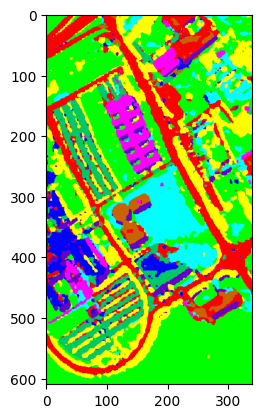

In [4]:
if __name__ == '__main__':

    work_dir = "./work_dir"
    setting_name = 'tr{}val{}'.format(str(args.train_samples),str(args.val_samples)) + '_lr{}'.format(str(learning_rate)) + '_{}'.format(args.mamba_type)

    if 'spe' in args.mamba_type or args.mamba_type=='both':
        setting_name = setting_name + '_token{}'.format(str(args.token_num))

    if args.patch_size>1:
        setting_name = setting_name + '_P{}'.format(args.patch_size)
    setting_name = setting_name + '_HD{}'.format(args.hidden_dim)

    dataset_name = data_set_name

    exp_name = args.exp_name
    if model_flag==0:
        save_folder = os.path.join(work_dir, exp_name, net_name, setting_name, dataset_name)
    else:
        save_folder = os.path.join(work_dir, exp_name, net_name, dataset_name)

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
        print("makedirs {}".format(save_folder))

    save_log_path = os.path.join(save_folder,'train_tr{}_val{}.log'.format(num_list[0],num_list[1]))

    torch.cuda.empty_cache()

    print(save_folder)

    data, gt = data_load_operate.load_data(data_set_name, data_set_path)

    height, width, channels = data.shape

    gt_reshape = gt.reshape(-1)
    height, width, channels = data.shape
    img = ImageStretching(data)

    class_count = max(np.unique(gt))

    flag_list = [1, 0]  # ratio or num
    ratio_list = [0.1, 0.01]  # [train_ratio,val_ratio]

    loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1)

    OA_ALL = []
    AA_ALL = []
    KPP_ALL = []
    EACH_ACC_ALL = []
    Train_Time_ALL = []
    Test_Time_ALL = []
    CLASS_ACC = np.zeros([len(seed_list), class_count])
    evaluator = Evaluator(num_class=class_count)

    for exp_idx,curr_seed in enumerate(seed_list):
        setup_seed(curr_seed)
        single_experiment_name = 'run{}_seed{}'.format(str(exp_idx), str(curr_seed))
        save_single_experiment_folder = os.path.join(save_folder, single_experiment_name)
        if not os.path.exists(save_single_experiment_folder):
            os.mkdir(save_single_experiment_folder)
        save_vis_folder = os.path.join(save_single_experiment_folder, 'vis')
        if not os.path.exists(save_vis_folder):
            os.makedirs(save_vis_folder)
            print("makedirs {}".format(save_vis_folder))

        save_weight_path = os.path.join(save_single_experiment_folder, "best_tr{}_val{}.pth".format(num_list[0], num_list[1]))
        results_save_path = os.path.join(save_single_experiment_folder, 'result_tr{}_val{}.txt'.format(num_list[0], num_list[1]))
        predict_save_path = os.path.join(save_single_experiment_folder, 'pred_vis_tr{}_val{}.png'.format(num_list[0], num_list[1]))
        gt_save_path = os.path.join(save_single_experiment_folder, 'gt_vis_tr{}_val{}.png'.format(num_list[0], num_list[1]))

        train_data_index, val_data_index, test_data_index, all_data_index = data_load_operate.sampling(ratio_list,
                                                                                                       num_list,
                                                                                                       gt_reshape,
                                                                                                       class_count,
                                                                                                       flag_list[0])
        index = (train_data_index, val_data_index, test_data_index)
        train_label, val_label, test_label = data_load_operate.generate_image_iter(data, height, width, gt_reshape, index)

        # build Model
        net = CommonTemplate(net_name=net_name,in_channels=channels,num_classes=class_count,height=height,width=width,args=args)


        x = transform(np.array(img))
        x = x.unsqueeze(0).float().to(device)

        train_label = train_label.to(device)
        test_label = test_label.to(device)
        val_label = val_label.to(device)

        net.to(device)

        train_loss_list = [100]
        train_acc_list = [0]
        val_loss_list = [100]
        val_acc_list = [0]

        optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
        
        best_loss = 99999

        tic1 = time.perf_counter()
        best_val_acc = 0
      

        for epoch in range(max_epoch):
            y_train = train_label.unsqueeze(0)
            train_acc_sum, trained_samples_counter = 0.0, 0
            batch_counter, train_loss_sum = 0, 0
            time_epoch = time.time()
            loss_dict = {}
        
            net.train()
 
            
            data_dict = net(x)
            y_pred = data_dict['logits']
            ls = head_loss(loss_func,y_pred, y_train.long())

            logits_dict = data_dict['logits_dict']
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
            print('Iter:{}|loss:{}|loss_dict:{}'.format(epoch, ls.detach().cpu().numpy(), loss_dict))
               
            torch.cuda.empty_cache()
            # evaluate stage
            net.eval()
            with torch.no_grad():
                evaluator.reset()
                val_data_dict = net(x)
                output_val = val_data_dict['logits']
                y_val = val_label.unsqueeze(0)
                seg_logits = resize(input=output_val,
                                    size=y_val.shape[1:],
                                    mode='bilinear',
                                    align_corners=True)
                predict = torch.argmax(seg_logits,dim=1).cpu().numpy()
                Y_val_np = val_label.cpu().numpy()
                Y_val_255 = np.where(Y_val_np==-1,255,Y_val_np)
                evaluator.add_batch(np.expand_dims(Y_val_255,axis=0),predict)
                OA = evaluator.Pixel_Accuracy()
                mIOU, IOU = evaluator.Mean_Intersection_over_Union()
                mAcc, Acc = evaluator.Pixel_Accuracy_Class()
                Kappa = evaluator.Kappa()
                print('Evaluate {}|OA:{}|MACC:{}|Kappa:{}|MIOU:{}|IOU:{}|ACC:{}'.format(epoch, OA,mAcc,Kappa,mIOU,IOU,Acc))
                # save weight
                if OA>=best_val_acc:
                    best_epoch = epoch + 1
                    best_val_acc = OA
                    torch.save(net.state_dict(), save_weight_path)
                if (epoch+1)%50==0:
                    save_single_predict_path = os.path.join(save_vis_folder,'predict_{}.png'.format(str(epoch+1)))
                    save_single_gt_path = os.path.join(save_vis_folder,'gt.png')
                    vis_a_image(gt,predict,save_single_predict_path, save_single_gt_path)


            torch.cuda.empty_cache()


        print("\n\n====================Starting evaluation for testing set.========================\n")
        pred_test = []

        load_weight_path = save_weight_path
        net.update_params = None
   
        best_net = CommonTemplate(net_name=net_name, in_channels=channels, num_classes=class_count, height=height,
                             width=width, args=args)
    
        best_net.to(device)
        best_net.load_state_dict(torch.load(load_weight_path))
        best_net.eval()
        test_evaluator = Evaluator(num_class=class_count)
        with torch.no_grad():
            test_evaluator.reset()
            test_data_dict = best_net(x)
            output_test = test_data_dict['logits']
            # output_test = best_net(x)
            y_test = test_label.unsqueeze(0)
            seg_logits_test = resize(input=output_test,
                                size=y_test.shape[1:],
                                mode='bilinear',
                                align_corners=True)
            predict_test = torch.argmax(seg_logits_test, dim=1).cpu().numpy()
            Y_test_np = test_label.cpu().numpy()
            Y_test_255 = np.where(Y_test_np == -1, 255, Y_test_np)
            test_evaluator.add_batch(np.expand_dims(Y_test_255, axis=0), predict_test)
            OA_test = test_evaluator.Pixel_Accuracy()
            mIOU_test, IOU_test = test_evaluator.Mean_Intersection_over_Union()
            mAcc_test, Acc_test = test_evaluator.Pixel_Accuracy_Class()
            Kappa_test = evaluator.Kappa()
            print('Test {}|OA:{}|MACC:{}|Kappa:{}|MIOU:{}|IOU:{}|ACC:{}'.format(epoch, OA_test, mAcc_test, Kappa_test, mIOU_test, IOU_test,
                                                                                    Acc_test))
            
        # Output infors
        print("\n\n==================== testing Result on {}========================\n".format(dataset_name))
        str_results = '\n======================' \
                      + " exp_idx=" + str(exp_idx) \
                      + " seed=" + str(curr_seed) \
                      + " learning rate=" + str(learning_rate) \
                      + " epochs=" + str(max_epoch) \
                      + " train ratio=" + str(ratio_list[0]) \
                      + " val ratio=" + str(ratio_list[1]) \
                      + " ======================" \
                      + "\nOA=" + str(OA_test) \
                      + "\nAA=" + str(mAcc_test) \
                      + '\nkpp=' + str(Kappa_test) + "\n"
        print(str_results)
        vis_a_image(gt, predict_test, predict_save_path, gt_save_path)
        predict_img = plt.imread(predict_save_path)
        plt.imshow(predict_img)
        torch.cuda.empty_cache()

